In [105]:
import sys
sys.path.append("/Users/eric/Workspace/wangLab/orofacial")

import orofacial

h5_path = "data/phox2b38_20240307_1_tongue.h5"

h5 = orofacial.tongue_mask_processing.TongueArchive(h5_path)
display(len(h5.frames))
display(h5.frames[0:5])



64645

array([4017, 4018, 4021, 4022, 4023])

In [149]:
import tqdm

imgs = []

for i in tqdm.tqdm(range(10000)):
    imgs.append((orofacial.tongue_mask_processing.plot_frame_bool(h5, i, 260, 360), h5.frames[i]))

    

100%|██████████| 10000/10000 [00:01<00:00, 5640.04it/s]


In [150]:
imgs = list(map(lambda x : (orofacial.tongue_mask_processing.keep_largest_cc(x[0]), x[1]), tqdm.tqdm(imgs)))

100%|██████████| 10000/10000 [00:03<00:00, 2564.79it/s]


In [151]:
import numpy as np
imgs = list(filter(lambda x : np.count_nonzero(x[0]) > 10, tqdm.tqdm(imgs)))

100%|██████████| 10000/10000 [00:00<00:00, 176438.84it/s]


In [152]:
coords = list(map(lambda x : orofacial.tongue_tip_track_2D.find_tongue_tip(x[0]), tqdm.tqdm(imgs)))

100%|██████████| 9654/9654 [02:08<00:00, 74.99it/s] 


In [155]:

import matplotlib.pyplot as plt
import numpy as np

for i in range(len(coords)):
    if coords[i][0] < 50 or coords[i][1] < 90:
        plt.imsave(f"problem_tongue_{i}.png", imgs[i][0])

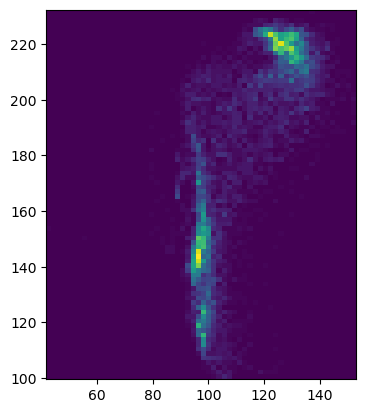

In [157]:
import matplotlib.pyplot as plt
import numpy as np
bad = 0

c = list(filter(lambda x : isinstance(x, np.ndarray), coords))
x, y = np.column_stack(c)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(60, 80))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='upper')
plt.show()


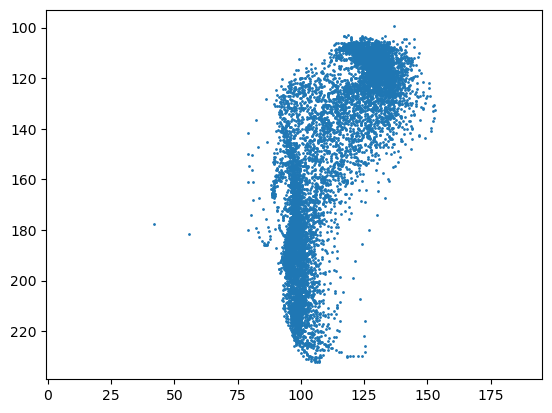

In [158]:
plt.axis("equal")
plt.gca().invert_yaxis()
plt.scatter(x, y, s=1)


Assumption that each lick is separated by a consecutive window of empty frames

In [162]:
licks = [[coords[0]]]
for i in range(1, len(coords)):
    if isinstance(coords[i], np.ndarray):
        if imgs[i][1] != imgs[i-1][1] + 1:
            licks.append([coords[i]])
        else:
            licks[-1].append(coords[i])

len(licks)

463

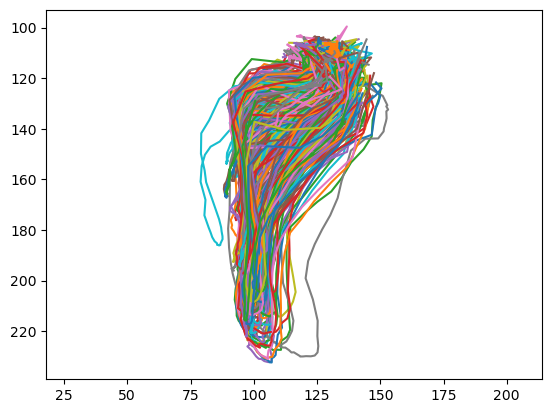

In [169]:
plt.gca().invert_yaxis()
plt.axis("equal")
for p in licks:
    x, y = np.column_stack(p)
    if len(x) > 1:
        plt.plot(x, y)

In [126]:
import os, subprocess, glob

def generate_video(img):
    # for i in tqdm.tqdm(range(len(img))):
    #     plt.clf()
    #     plt.imshow(img[i], cmap="gray")
    #     plt.scatter(x = coords[i][0], y = coords[i][1], c = "r", s = 10);
    #     plt.savefig("output/file%02d.png" % i)

    #os.chdir("output")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name2.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

generate_video(imgs)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 15.0.7
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1696213832120/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1696213832120/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --en

### Averaging tongue trajectories

Each curve is defined as a sequence of $(x_1, y_1),\ldots$

First curves will be parametized with respect to arc length (euclidean distance)

Parametization will then be normalized such that $1$ is always the end of the curve, no matter which.

The final curve will be the average of all curves through enumeration of the arc length variable


In [171]:
import scipy

def interp(p):
    pp = [p[0]]
    for i in range(1, len(p)):
        if np.linalg.norm(np.array(p[i]) - np.array(pp[-1])) > 0.001:
            pp.append(p[i])
    p = pp

    tck, u = scipy.interpolate.splprep(np.column_stack(p), s=0) 
    t = np.linspace(0, 1, 100)  # Get 100 interpolated points
    x_new, y_new = scipy.interpolate.splev(t, tck)

    # Resulting interpolated trajectory (list of tuples)
    return list(zip(x_new, y_new))

licks_p = []
for i in range(len(licks)):
    if len(licks[i]) > 3:
        licks_p.append(interp(licks[i]))

display("len", len(licks_p))
#licks_p = [interp(p) for p in filter(lambda x : len(x) > 3, licks)]

'len'

339

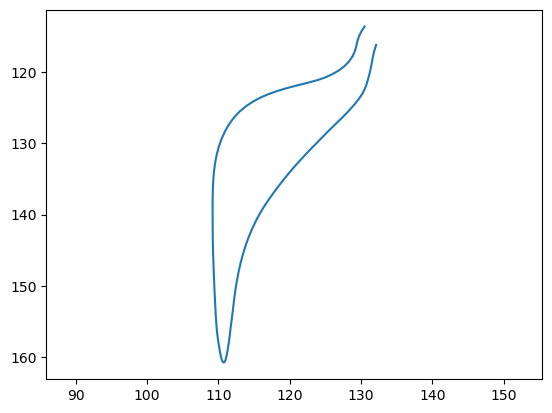

In [173]:

avg_p = np.mean(licks_p, axis=0)

plt.gca().invert_yaxis()
plt.axis('equal')

plt.plot(avg_p[:, 0], avg_p[:, 1])

83

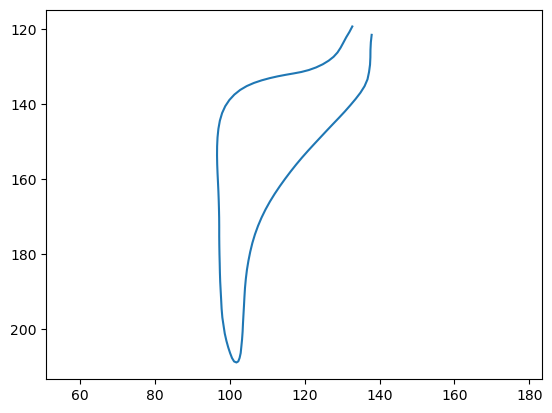

In [174]:

licks_p_big = [p for p in licks_p if max(np.column_stack(p)[1])>200]
display(len(licks_p_big))
avg_p = np.mean(licks_p_big, axis=0)

plt.gca().invert_yaxis()
plt.axis('equal')

plt.plot(avg_p[:, 0], avg_p[:, 1])

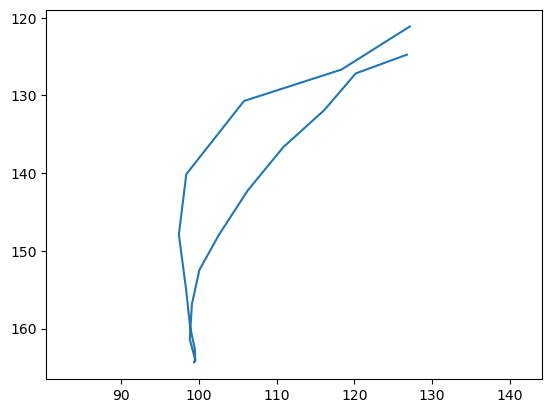

In [175]:

plt.gca().invert_yaxis()
plt.axis('equal')
x, y = np.column_stack(licks[7])
plt.plot(x, y)